In [4]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import itertools
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from IPython.display import Image
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import classification_report, mean_squared_error,r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
import os

In [3]:
sensors = pd.read_csv('../Cleaned_data/all_sensors_clean.csv')

# Using limited sensors (2,6,9,10,14,18)

## Use daily average counts from previous year and location features as predictors 


In [11]:
#returns dataframe with average daily counts for specified sensor and year
def counts_per_sensor_year(sensor_num, year):
    #get sensor counts for specified sensor and year
    df = sensors[(sensors.sensor_id ==sensor_num) & (sensors.year == year)]
    df2 = df[['datetime', 'Hourly_Counts']]
    df2.set_index('datetime', inplace = True)
    df2.index = pd.DatetimeIndex(df2.index).to_period('H')
    daily_df = df2.resample('1D').mean()
    daily_df.rename(columns = {'Hourly_Counts': 'daily_avg_counts'}, inplace = True)
    
    daily_df['month'] = daily_df.index.month
    daily_df['day'] = daily_df.index.day
    daily_df['sensor_id'] = sensor_num
    daily_df['year'] = year
    return daily_df

In [5]:
#returns dataframe with average daily counts and features attached
def features_per_sensor_year(sensor_num, year):
    loc = pd.read_csv('/Users/Jewel/Desktop/capstone - melbourne data/features_{}_limited.csv'.format(year))
    return loc[loc.sensor_id == sensor_num].merge(counts_per_sensor_year(sensor_num, year), how = 'inner', on = 'sensor_id')

In [6]:
#returns full dataframe with daily counts, features, and previous year counts
def counts_prev_year(sensor_num, year):
    #get counts for specified sensor the year before
    prev_df = sensors[(sensors.sensor_id ==sensor_num) & (sensors.year == year - 1)]
    prev_df2 = prev_df[['datetime', 'Hourly_Counts']]
    prev_df2.set_index('datetime', inplace = True)
    prev_df2.index = pd.DatetimeIndex(prev_df2.index).to_period('H')
    prev_daily_df = prev_df2.resample('1D').mean()
    prev_daily_df.rename(columns = {'Hourly_Counts': 'prev_year_counts'}, inplace = True)
    
    prev_daily_df['month'] = prev_daily_df.index.month
    prev_daily_df['day'] = prev_daily_df.index.day

    
    #match sensor counts from previous year as a feature for predicting specified year counts
    full_df = pd.merge(prev_daily_df, features_per_sensor_year(sensor_num, year), on=['month', 'day'])
    return full_df

In [7]:
def limited_sensors_per_year(year):
    df =  pd.concat([counts_prev_year(2, year), counts_prev_year(3, year), counts_prev_year(6, year),
                     counts_prev_year(8, year), counts_prev_year(9, year), 
                    counts_prev_year(10, year), counts_prev_year(14, year), counts_prev_year(18, year)])
    df.fillna(method='ffill', inplace = True)
    return df


## Limited Sensors
### predict hourly counts with location, date and previous year's counts as predictors
### using sensors 2, 3, 6, 8, 9, 10, 14, 18 from 2011-2018, randomly splitting sensors from 2011-2018 into train and test groups

In [7]:
X = pd.concat([limited_sensors_per_year(2012), limited_sensors_per_year(2013), 
               limited_sensors_per_year(2014), limited_sensors_per_year(2015),
              limited_sensors_per_year(2016), limited_sensors_per_year(2017),
              limited_sensors_per_year(2018)], axis = 0, sort = True)
y = X.pop('daily_avg_counts')


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [8]:
X

Barbeque  Bicycle Rails  Bin Corral  Bollard  Commercial Accommodation  \
0           0             26           0       80                       1.0   
1           0             26           0       80                       1.0   
2           0             26           0       80                       1.0   
3           0             26           0       80                       1.0   
4           0             26           0       80                       1.0   
..        ...            ...         ...      ...                       ...   
360         0             29           0       29                       0.0   
361         0             29           0       29                       0.0   
362         0             29           0       29                       0.0   
363         0             29           0       29                       0.0   
364         0             29           0       29                       0.0   

     Community Use  Community Use.1  Drinking Fountain  Education Centre  \
0                1              0.0                  3                 0   
1                1              0.0                  3                 0   
2                1              0.0                  3                 0   
3                1              0.0                  3                 0   
4                1              0.0                  3                 0   
..             ...              ...                ...               ...   
360              0              0.0                  1                 0   
361              0              0.0                  1                 0   
362              0              0.0                  1                 0   
363              0              0.0                  1                 0   
364              0              0.0                  1                 0   

     Educational/Research  ...  Wholesale  Workshop/Studio  avg_n_floors  day  \
0                     1.0  ...        0.0              0.0      6.266667    1   
1                     1.0  ...        0.0              0.0      6.266667    2   
2                     1.0  ...        0.0              0.0      6.266667    3   
3                     1.0  ...        0.0              0.0      6.266667    4   
4                     1.0  ...        0.0              0.0      6.266667    5   
..                    ...  ...        ...              ...           ...  ...   
360                   0.0  ...        0.0              0.0      9.945455   27   
361                   0.0  ...        0.0              0.0      9.945455   28   
362                   0.0  ...        0.0              0.0      9.945455   29   
363                   0.0  ...        0.0              0.0      9.945455   30   
364                   0.0  ...        0.0              0.0      9.945455   31   

     month  num_bikes  num_lights  prev_year_counts  sensor_id  year  
0        1          0          44        816.875000          2  2012  
1        1          0          44       1096.375000          2  2012  
2        1          0          44       1022.583333          2  2012  
3        1          0          44       1252.500000          2  2012  
4        1          0          44       1307.375000          2  2012  
..     ...        ...         ...               ...        ...   ...  
360     12          0           0        168.333333         18  2018  
361     12          0           0        174.833333         18  2018  
362     12          0           0        164.375000         18  2018  
363     12          0           0         91.083333         18  2018  
364     12          0           0        108.875000         18  2018  

[15330 rows x 65 columns]

In [15]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

In [16]:
#standardize
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### Linear Regression

In [17]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
print('Training score: ', model.score(X_train, y_train))
print('Test score: ', model.score(X_test, y_test))
print('CV score: ', (cross_val_score(model, X_train, y_train)).mean())

Training score:  0.7721941700041325
Test score:  0.7668878862756047
CV score:  0.770676648821923


In [19]:
predictions = model.predict(X_test)
residuals = pd.DataFrame(predictions, y_test)
residuals.reset_index(inplace = True)
residuals.rename({'daily_avg_counts': 'y_test', 0: 'predictions'}, axis = 1, inplace = True)
residuals['residuals'] = residuals.y_test - residuals.predictions
residuals

y_test  predictions   residuals
0      506.416667   369.092685  137.323981
1      818.916667   941.223112 -122.306446
2      927.375000   961.316575  -33.941575
3      398.500000   318.409522   80.090478
4      575.333333   424.388710  150.944623
...           ...          ...         ...
3061   588.458333  1169.710676 -581.252342
3062   351.916667   336.599973   15.316693
3063  1258.625000  1417.395512 -158.770512
3064   917.666667   498.892358  418.774308
3065   634.333333   433.830117  200.503217

[3066 rows x 3 columns]

In [20]:
(mean_squared_error(y_test, predictions))**0.5

220.09939299054304

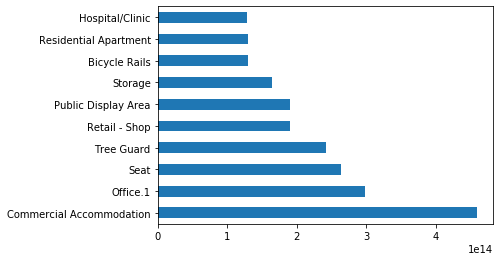

In [21]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients to gauge influence (show importance of predictor variables)
df_coef['coef_abs'] = df_coef.coefficients.abs()

# plot the magnitude of the coefficients
df_coef['coefficients'].sort_values(ascending = False)[:10].plot(kind='barh');

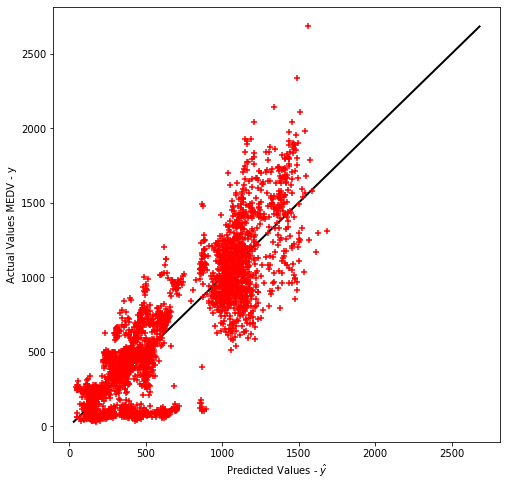

In [22]:
#predicted y values
predictions = model.predict(X_test)

#residuals (or error between predictions and actual)
residuals = y_test - predictions

# Plot predicted vs actual 
plt.figure(figsize=(8,8))
plt.scatter(predictions, y_test, s=30, c='r', marker='+', zorder=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='k', lw=2)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values MEDV - y")
plt.show()

# Adding ALL sensors 

### creating dataframe with previous year data

In [4]:
#returns dataframe with average daily counts for specified sensor and year

def full_counts_per_sensor_year(sensor_num, year):
    #get sensor counts for specified sensor and year
    try:
        df = sensors[(sensors.sensor_id ==sensor_num) & (sensors.year == year)]
        df2 = df[['datetime', 'Hourly_Counts']]
        df2.set_index('datetime', inplace = True)
        df2.index = pd.DatetimeIndex(df2.index).to_period('H')
        daily_df = df2.resample('1D').mean()
        daily_df.rename(columns = {'Hourly_Counts': 'daily_avg_counts'}, inplace = True)

        daily_df['weekday'] = daily_df.index.weekday
        daily_df['month'] = daily_df.index.month
        daily_df['day'] = daily_df.index.day
        daily_df['sensor_id'] = sensor_num
        daily_df['year'] = year
    
    except:
        
        #if there is no records for that year, take records from previous year
        try:
            df = sensors[(sensors.sensor_id ==sensor_num) & (sensors.year == year-1)]
            df2 = df[['datetime', 'Hourly_Counts']]
            df2.set_index('datetime', inplace = True)
            df2.index = pd.DatetimeIndex(df2.index).to_period('H')
            daily_df = df2.resample('1D').mean()
            daily_df.rename(columns = {'Hourly_Counts': 'daily_avg_counts'}, inplace = True)

            daily_df['weekday'] = daily_df.index.weekday
            daily_df['month'] = daily_df.index.month
            daily_df['day'] = daily_df.index.day
            daily_df['sensor_id'] = sensor_num
            daily_df['year'] = year-1
        except:
            
            #if there is no records from previous year, take records from 2 years ago
            try:
                df = sensors[(sensors.sensor_id ==sensor_num) & (sensors.year == year-2)]
                df2 = df[['datetime', 'Hourly_Counts']]
                df2.set_index('datetime', inplace = True)
                df2.index = pd.DatetimeIndex(df2.index).to_period('H')
                daily_df = df2.resample('1D').mean()
                daily_df.rename(columns = {'Hourly_Counts': 'daily_avg_counts'}, inplace = True)

                daily_df['weekday'] = daily_df.index.weekday
                daily_df['month'] = daily_df.index.month
                daily_df['day'] = daily_df.index.day
                daily_df['sensor_id'] = sensor_num
                daily_df['year'] = year-2
                
            except:
                daily_df = pd.DataFrame(columns = ['daily_avg_counts', 'month', 'day', 'sensor_id', 'year', 'datetime'])
                daily_df.set_index('datetime', inplace = True)
    return daily_df

In [5]:
#returns dataframe with average daily counts and features attached
def full_features_per_sensor_year(sensor_num, year):
    loc = pd.read_csv('/Users/Jewel/Desktop/capstone - melbourne data/location features/full/full_features_{}.csv'.format(year))
    return loc[loc.sensor_id == sensor_num].merge(full_counts_per_sensor_year(sensor_num, year), how = 'inner', on = 'sensor_id')

In [6]:
full_features_per_sensor_year(3, 2012)

sensor_id  Bicycle Rails  Litter Bin  Seat  Bollard  Hoop  \
0            3             41          32    42       10     0   
1            3             41          32    42       10     0   
2            3             41          32    42       10     0   
3            3             41          32    42       10     0   
4            3             41          32    42       10     0   
..         ...            ...         ...   ...      ...   ...   
361          3             41          32    42       10     0   
362          3             41          32    42       10     0   
363          3             41          32    42       10     0   
364          3             41          32    42       10     0   
365          3             41          32    42       10     0   

     Information Pillar  Floral Crate/Planter Box  Tree Guard  \
0                     2                         0           8   
1                     2                         0           8   
2                     2                         0           8   
3                     2                         0           8   
4                     2                         0           8   
..                  ...                       ...         ...   
361                   2                         0           8   
362                   2                         0           8   
363                   2                         0           8   
364                   2                         0           8   
365                   2                         0           8   

     Drinking Fountain  ...  Unoccupied - Under Demolition/Condemned  \
0                    3  ...                                      0.0   
1                    3  ...                                      0.0   
2                    3  ...                                      0.0   
3                    3  ...                                      0.0   
4                    3  ...                                      0.0   
..                 ...  ...                                      ...   
361                  3  ...                                      0.0   
362                  3  ...                                      0.0   
363                  3  ...                                      0.0   
364                  3  ...                                      0.0   
365                  3  ...                                      0.0   

     Transport.1  avg_n_floors  num_bikes  num_lights  daily_avg_counts  \
0            0.0      4.186869          1          31       1156.333333   
1            0.0      4.186869          1          31        715.083333   
2            0.0      4.186869          1          31        797.625000   
3            0.0      4.186869          1          31        877.583333   
4            0.0      4.186869          1          31        962.541667   
..           ...           ...        ...         ...               ...   
361          0.0      4.186869          1          31       1230.791667   
362          0.0      4.186869          1          31       1294.416667   
363          0.0      4.186869          1          31       1185.208333   
364          0.0      4.186869          1          31       1047.958333   
365          0.0      4.186869          1          31       1423.666667   

     weekday  month  day  year  
0          6      1    1  2012  
1          0      1    2  2012  
2          1      1    3  2012  
3          2      1    4  2012  
4          3      1    5  2012  
..       ...    ...  ...   ...  
361        3     12   27  2012  
362        4     12   28  2012  
363        5     12   29  2012  
364        6     12   30  2012  
365        0     12   31  2012  

[366 rows x 66 columns]

In [7]:
#returns full dataframe with daily counts, features, and previous year counts
def full_counts_prev_year(sensor_num, year):
    
    #try to get counts for specified sensor the year before
    try:
        prev_df = sensors[(sensors.sensor_id ==sensor_num) & (sensors.year == year - 1)]
        prev_df2 = prev_df[['datetime', 'Hourly_Counts']]
        prev_df2.set_index('datetime', inplace = True)
        prev_df2.index = pd.DatetimeIndex(prev_df2.index).to_period('H')
        prev_daily_df = prev_df2.resample('1D').mean()
        prev_daily_df.rename(columns = {'Hourly_Counts': 'prev_year_counts'}, inplace = True)

        prev_daily_df['month'] = prev_daily_df.index.month
        prev_daily_df['day'] = prev_daily_df.index.day
    
    except:
        #if no records from previous year, get records from 2 years ago
        try:
            prev_df = sensors[(sensors.sensor_id ==sensor_num) & (sensors.year == year - 2)]
            prev_df2 = prev_df[['datetime', 'Hourly_Counts']]
            prev_df2.set_index('datetime', inplace = True)
            prev_df2.index = pd.DatetimeIndex(prev_df2.index).to_period('H')
            prev_daily_df = prev_df2.resample('1D').mean()
            prev_daily_df.rename(columns = {'Hourly_Counts': 'prev_year_counts'}, inplace = True)

            prev_daily_df['month'] = prev_daily_df.index.month
            prev_daily_df['day'] = prev_daily_df.index.day
            
        except:
            #if no records from previous 2 years, get records from 3 years ago
            try:
                prev_df = sensors[(sensors.sensor_id ==sensor_num) & (sensors.year == year - 3)]
                prev_df2 = prev_df[['datetime', 'Hourly_Counts']]
                prev_df2.set_index('datetime', inplace = True)
                prev_df2.index = pd.DatetimeIndex(prev_df2.index).to_period('H')
                prev_daily_df = prev_df2.resample('1D').mean()
                prev_daily_df.rename(columns = {'Hourly_Counts': 'prev_year_counts'}, inplace = True)

                prev_daily_df['month'] = prev_daily_df.index.month
                prev_daily_df['day'] = prev_daily_df.index.day
                
            except:
                pass

    
    #match sensor counts from previous year as a feature for predicting specified year counts
    full_df = pd.merge(prev_daily_df, full_features_per_sensor_year(sensor_num, year), on=['month', 'day'])
    return full_df

In [8]:
full_counts_prev_year(2, 2012)

prev_year_counts  month  day  sensor_id  Bicycle Rails  Litter Bin  Seat  \
0          816.875000      1    1          2             26          17    84   
1         1096.375000      1    2          2             26          17    84   
2         1022.583333      1    3          2             26          17    84   
3         1252.500000      1    4          2             26          17    84   
4         1307.375000      1    5          2             26          17    84   
..                ...    ...  ...        ...            ...         ...   ...   
360       1589.000000     12   27          2             26          17    84   
361       1632.125000     12   28          2             26          17    84   
362       1563.041667     12   29          2             26          17    84   
363       1641.583333     12   30          2             26          17    84   
364       1280.750000     12   31          2             26          17    84   

     Bollard  Hoop  Information Pillar  ...  Retail - Stall  Retail - Cars  \
0         80     0                   2  ...             0.0            0.0   
1         80     0                   2  ...             0.0            0.0   
2         80     0                   2  ...             0.0            0.0   
3         80     0                   2  ...             0.0            0.0   
4         80     0                   2  ...             0.0            0.0   
..       ...   ...                 ...  ...             ...            ...   
360       80     0                   2  ...             0.0            0.0   
361       80     0                   2  ...             0.0            0.0   
362       80     0                   2  ...             0.0            0.0   
363       80     0                   2  ...             0.0            0.0   
364       80     0                   2  ...             0.0            0.0   

     Unoccupied - Under Demolition/Condemned  Transport.1  avg_n_floors  \
0                                        0.0          0.0      6.266667   
1                                        0.0          0.0      6.266667   
2                                        0.0          0.0      6.266667   
3                                        0.0          0.0      6.266667   
4                                        0.0          0.0      6.266667   
..                                       ...          ...           ...   
360                                      0.0          0.0      6.266667   
361                                      0.0          0.0      6.266667   
362                                      0.0          0.0      6.266667   
363                                      0.0          0.0      6.266667   
364                                      0.0          0.0      6.266667   

     num_bikes  num_lights  daily_avg_counts  weekday  year  
0            0          44        706.083333        6  2012  
1            0          44        762.000000        0  2012  
2            0          44       1137.708333        1  2012  
3            0          44       1299.333333        2  2012  
4            0          44       1357.333333        3  2012  
..         ...         ...               ...      ...   ...  
360          0          44       1558.833333        3  2012  
361          0          44       1658.125000        4  2012  
362          0          44       1331.458333        5  2012  
363          0          44       1198.416667        6  2012  
364          0          44       1423.083333        0  2012  

[365 rows x 67 columns]

In [9]:
def full_sensors_per_year(year, year_list):
    df =  pd.DataFrame([])
    for x in year_list:
        try:
            df = df.append(full_counts_prev_year(x, year))
        except:
            pass
        
    df.fillna(method='ffill', inplace = True)
    return df


In [10]:
#sensors valid for entire year:
    
sen_2011 = [2,3,4,5,6,7,8,9,10,11,12,14,15,17,18]

sen_2012 = [1,2,3,4,5,6,7,8,9,10,11,12,14,17,18]

sen_2013 = [1,2,3,4,5,6,7,8,9,10,11,14,15,17,18]

sen_2014 = [2,3,4,5,6,8,9,10,11,12,14,15,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]

sen_2015 = [2,3,4,5,6,7,8,9,10,11,12,14,15,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,33,34,36,39,40]

sen_2016 = [1,2,3,5,6,7,8,9,10,12,14,18,19,20,21,23,24,25,26,27,28,29,30,31,33,34,36,37,39,40,42,43,44,53]

sen_2017 = [1,2,3,6,7,8,9,10,11,12,14,15,17,18,19,20,21,23,24,25,26,27,28,29,30,31,33,34,35,36,37,39,40,42,43,44,53]

sen_2018 = [1,2,3,4,5,6,7,8,9,10,11,12,14,15,18,19,20,21,23,24,25,26,27,28,29,30,31,33,34,35,36,37,40,42,43,44,45,46,47,49,50,51,52,53]

sen_2019 = [1,2,4,5,6,7,9,10,11,12,14,15,18,19,20,21,23,24,26,27,28,30,31,34,36,37,39,40,42,43,44,46,47,48,49,50,51,52,53,54,56, 57,58]

In [11]:
all_sen_2012 = full_sensors_per_year(2012, sen_2012)
all_sen_2013 = full_sensors_per_year(2013, sen_2013)
all_sen_2014 = full_sensors_per_year(2014, sen_2014)
all_sen_2015 = full_sensors_per_year(2015, sen_2015)
all_sen_2016 = full_sensors_per_year(2016, sen_2016)
all_sen_2017 = full_sensors_per_year(2017, sen_2017)
all_sen_2018 = full_sensors_per_year(2018, sen_2018)

In [24]:
#export to csv sensors from all years with previous year counts

all_sensors_prev_years = pd.concat([all_sen_2012, all_sen_2013, all_sen_2014, all_sen_2015, all_sen_2016, all_sen_2017,
              all_sen_2018], axis = 0, sort = True)
all_sensors_prev_years.to_csv('/Users/Jewel/Desktop/capstone - melbourne data/all_sensors_prev_years.csv', header = all_sensors_prev_years.columns, index=False)


# Predicting with All Sensors (using all data split train/test)
### predict hourly counts with location, date and previous year's counts as predictors
### randomly splitting all valid sensors from 2011-2018 into train and test groups
*best CV score = Decision Tree .917 HOWEVER this model does not forecast, it is performing well since all years are in train and test groups. For the next modelling, I will look at splitting the train and test groups by year to see if location and previous year counts can allow us to forecast footfall.

In [25]:
X = pd.concat([all_sen_2012, all_sen_2013, all_sen_2014, all_sen_2015, all_sen_2016, all_sen_2017,
              all_sen_2018], axis = 0, sort = True)
y = X.pop('daily_avg_counts')


In [26]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

In [27]:
#standardize
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### Linear Regression

In [111]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [112]:
print('Training score: ', model.score(X_train, y_train))
print('Test score: ', model.score(X_test, y_test))
print('CV score: ', (cross_val_score(model, X_train, y_train)).mean())

Training score:  0.831029158759354
Test score:  0.8303004689270322
CV score:  0.8306526340005039


In [113]:
predictions = model.predict(X_test)
residuals = pd.DataFrame(predictions, y_test)
residuals.reset_index(inplace = True)
residuals.rename({'daily_avg_counts': 'y_test', 0: 'predictions'}, axis = 1, inplace = True)
residuals['residuals'] = residuals.y_test - residuals.predictions
residuals

y_test  predictions   residuals
0      1207.333333   681.954004  525.379330
1       529.916667   587.041115  -57.124449
2       321.458333   254.477420   66.980914
3       706.875000   323.340580  383.534420
4        86.375000   -48.897649  135.272649
...            ...          ...         ...
12454   203.291667   118.585910   84.705757
12455  1418.708333  1226.010895  192.697438
12456   360.583333   316.790464   43.792870
12457   371.291667   339.880725   31.410942
12458   394.416667   359.675929   34.740738

[12459 rows x 3 columns]

In [114]:
(mean_squared_error(y_test, predictions))**0.5

195.02736773916425

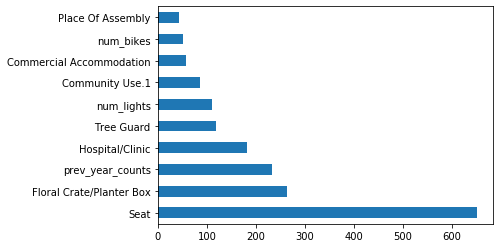

In [115]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model.coef_, index=X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients to gauge influence (show importance of predictor variables)
df_coef['coef_abs'] = df_coef.coefficients.abs()

# plot the magnitude of the coefficients
df_coef['coefficients'].sort_values(ascending = False)[:10].plot(kind='barh');

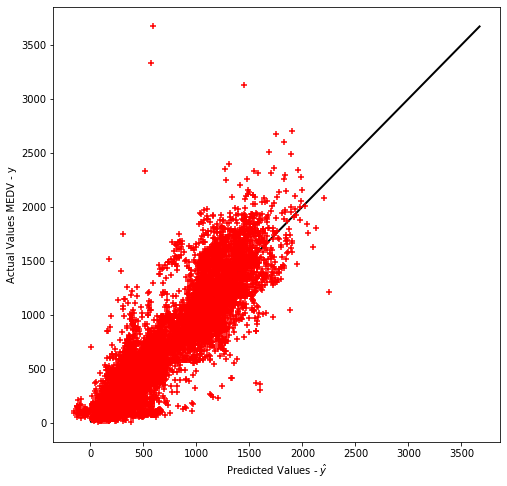

In [116]:
#predicted y values
predictions = model.predict(X_test)

#residuals (or error between predictions and actual)
residuals = y_test - predictions

# Plot predicted vs actual 
plt.figure(figsize=(8,8))
plt.scatter(predictions, y_test, s=30, c='r', marker='+', zorder=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='k', lw=2)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values MEDV - y")
plt.show()

### tune for best scores

#### Ridge with GridSearchCV

In [137]:
parameters = {'alpha': list(range(10)), 'fit_intercept': [True, False], 
              'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

# define the model/ estimator
model = Ridge(max_iter = 100000)

# define the grid search
ridge= GridSearchCV(model, parameters,cv=5)

#fit the grid search
ridge.fit(X_train,y_train)

# best estimator
print(ridge.best_estimator_)

# best model
best_model = ridge.best_estimator_
best_model.fit(X_train,y_train)

Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, random_state=None, solver='sag', tol=0.001)


Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, random_state=None, solver='sag', tol=0.001)

In [139]:
print('Training score: ', best_model.score(X_train, y_train))
print('Test score: ', best_model.score(X_test, y_test))
print('CV score: ', (cross_val_score(best_model, X_train, y_train)).mean())

Training score:  0.8310290311652919
Test score:  0.8302931666900183
CV score:  0.8306522518062962


#### Lasso with GridSearchCV

In [140]:
parameters = {'alpha': np.logspace(-4, 4, 10), 'fit_intercept': [True, False]}

# define the model/ estimator
model = Lasso(max_iter = 100000)

# define the grid search
lasso= GridSearchCV(model, parameters,cv=5)

#fit the grid search
lasso.fit(X_train,y_train)

# best estimator
print(lasso.best_estimator_)

# best model
best_model = lasso.best_estimator_
best_model.fit(X_train,y_train)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [141]:
print('Training score: ', best_model.score(X_train, y_train))
print('Test score: ', best_model.score(X_test, y_test))
print('CV score: ', (cross_val_score(best_model, X_train, y_train)).mean())

Training score:  0.8310291574249858
Test score:  0.8302997445721232
CV score:  0.8306526367044093


#### Decision Tree Regressor with GridSearchCV

In [29]:
dtr_params = {
    'max_depth': list(range(1, 11))+[None],
    'max_features': [None, 1, 2, 3],
    'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50],
    'ccp_alpha': [0, 0.001, 0.005, 0.009, 0.01, 0.05]
}


# set the gridsearch
model = DecisionTreeRegressor()
dtr_gs = GridSearchCV(model, dtr_params, cv=5, verbose=1, n_jobs=2)
dtr_gs.fit(X_train, y_train)
print(dtr_gs.best_params_)
best_model = dtr_gs.best_estimator_

Fitting 5 folds for each of 2904 candidates, totalling 14520 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.0s
[Parallel(n_jobs=2)]: Done 203 tasks      | elapsed:   17.5s
[Parallel(n_jobs=2)]: Done 703 tasks      | elapsed:   51.8s
[Parallel(n_jobs=2)]: Done 1403 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done 1935 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Done 2485 tasks      | elapsed:  4.6min
[Parallel(n_jobs=2)]: Done 3654 tasks      | elapsed:  5.9min
[Parallel(n_jobs=2)]: Done 4404 tasks      | elapsed:  7.5min
[Parallel(n_jobs=2)]: Done 5364 tasks      | elapsed: 10.1min
[Parallel(n_jobs=2)]: Done 6834 tasks      | elapsed: 12.5min
[Parallel(n_jobs=2)]: Done 8139 tasks      | elapsed: 16.2min
[Parallel(n_jobs=2)]: Done 9312 tasks      | elapsed: 18.5min
[Parallel(n_jobs=2)]: Done 11295 tasks      | elapsed: 23.5min
[Parallel(n_jobs=2)]: Done 13082 tasks      | elapsed: 28.4min
[Parallel(n_jobs=2)]: Done 14520 out of 14520 | elapsed: 3

{'ccp_alpha': 0, 'max_depth': None, 'max_features': None, 'min_samples_split': 50}


In [30]:
print('Training score: ', best_model.score(X_train, y_train))
print('Test score: ', best_model.score(X_test, y_test))
print('CV score: ', (cross_val_score(best_model, X_train, y_train)).mean())

Training score:  0.9440709074505427
Test score:  0.9190303296751863
CV score:  0.9170065066191808


# Use all sensors to predict 2017 & 2018 data
#### predict hourly counts with location, date and previous year's counts as predictors
#### using all valid sensors from 2011-2018
#### predict counts for 2017 & 2018 with previous years as train data
*best CV score = Ada Boost Regressor 0.84

In [15]:
train = pd.concat([all_sen_2012, all_sen_2013, all_sen_2014, all_sen_2015, all_sen_2016], axis = 0, sort = True)
test = pd.concat([all_sen_2018, all_sen_2017], axis = 0, sort = True)

X_train = train.copy()
y_train = X_train.pop('daily_avg_counts')

X_test = test.copy()
y_test = X_test.pop('daily_avg_counts')

In [16]:
X_train

Barbeque  Bicycle Rails  Bin Corral  Bollard  Commercial Accommodation  \
0           0             26           0       80                       1.0   
1           0             26           0       80                       1.0   
2           0             26           0       80                       1.0   
3           0             26           0       80                       1.0   
4           0             26           0       80                       1.0   
..        ...            ...         ...      ...                       ...   
341         0             34           0       15                       4.0   
342         0             34           0       15                       4.0   
343         0             34           0       15                       4.0   
344         0             34           0       15                       4.0   
345         0             34           0       15                       4.0   

     Community Use  Community Use.1  Drinking Fountain  Education Centre  \
0                1              0.0                  3                 0   
1                1              0.0                  3                 0   
2                1              0.0                  3                 0   
3                1              0.0                  3                 0   
4                1              0.0                  3                 0   
..             ...              ...                ...               ...   
341              0              0.0                  1                 0   
342              0              0.0                  1                 0   
343              0              0.0                  1                 0   
344              0              0.0                  1                 0   
345              0              0.0                  1                 0   

     Educational/Research  ...  Workshop/Studio  avg_n_floors  day  month  \
0                     1.0  ...              0.0      6.266667    1      1   
1                     1.0  ...              0.0      6.266667    2      1   
2                     1.0  ...              0.0      6.266667    3      1   
3                     1.0  ...              0.0      6.266667    4      1   
4                     1.0  ...              0.0      6.266667    5      1   
..                    ...  ...              ...           ...  ...    ...   
341                   1.0  ...              0.0     14.250000   27     12   
342                   1.0  ...              0.0     14.250000   28     12   
343                   1.0  ...              0.0     14.250000   29     12   
344                   1.0  ...              0.0     14.250000   30     12   
345                   1.0  ...              0.0     14.250000   31     12   

     num_bikes  num_lights  prev_year_counts  sensor_id  weekday  year  
0            0          44        816.875000          2        6  2012  
1            0          44       1096.375000          2        0  2012  
2            0          44       1022.583333          2        1  2012  
3            0          44       1252.500000          2        2  2012  
4            0          44       1307.375000          2        3  2012  
..         ...         ...               ...        ...      ...   ...  
341          0          13        124.541667         40        1  2016  
342          0          13        124.375000         40        2  2016  
343          0          13        189.791667         40        3  2016  
344          0          13        226.375000         40        4  2016  
345          0          13        170.083333         40        5  2016  

[36115 rows x 66 columns]

In [17]:
X_test

Barbeque  Bicycle Rails  Bin Corral  Bollard  Commercial Accommodation  \
0           0             31           0       77                       2.0   
1           0             31           0       77                       2.0   
2           0             31           0       77                       2.0   
3           0             31           0       77                       2.0   
4           0             31           0       77                       2.0   
..        ...            ...         ...      ...                       ...   
360         0             19           0       22                       3.0   
361         0             19           0       22                       3.0   
362         0             19           0       22                       3.0   
363         0             19           0       22                       3.0   
364         0             19           0       22                       3.0   

     Community Use  Community Use.1  Drinking Fountain  Education Centre  \
0                1              0.0                  4                 0   
1                1              0.0                  4                 0   
2                1              0.0                  4                 0   
3                1              0.0                  4                 0   
4                1              0.0                  4                 0   
..             ...              ...                ...               ...   
360              0              0.0                  1                 0   
361              0              0.0                  1                 0   
362              0              0.0                  1                 0   
363              0              0.0                  1                 0   
364              0              0.0                  1                 0   

     Educational/Research  ...  Workshop/Studio  avg_n_floors  day  month  \
0                     0.0  ...              0.0      5.096354    1      1   
1                     0.0  ...              0.0      5.096354    2      1   
2                     0.0  ...              0.0      5.096354    3      1   
3                     0.0  ...              0.0      5.096354    4      1   
4                     0.0  ...              0.0      5.096354    5      1   
..                    ...  ...              ...           ...  ...    ...   
360                   1.0  ...              1.0     11.336111   27     12   
361                   1.0  ...              1.0     11.336111   28     12   
362                   1.0  ...              1.0     11.336111   29     12   
363                   1.0  ...              1.0     11.336111   30     12   
364                   1.0  ...              1.0     11.336111   31     12   

     num_bikes  num_lights  prev_year_counts  sensor_id  weekday  year  
0            0          56        972.166667          1        0  2018  
1            0          56       1060.000000          1        1  2018  
2            0          56       1393.125000          1        2  2018  
3            0          56       1409.958333          1        3  2018  
4            0          56       1412.750000          1        4  2018  
..         ...         ...               ...        ...      ...   ...  
360          0           0        676.708333         53        2  2017  
361          0           0        751.875000         53        3  2017  
362          0           0        644.125000         53        4  2017  
363          0           0        741.458333         53        5  2017  
364          0           0        623.416667         53        6  2017  

[26176 rows x 66 columns]

In [18]:
#standardize
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

### Linear Regression

In [44]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [45]:
print('Training score: ', model.score(X_train, y_train))
print('Test score: ', model.score(X_test, y_test))
print('CV score: ', (cross_val_score(model, X_train, y_train)).mean())

Training score:  0.8406975290646816
Test score:  -1.8586066410080133
CV score:  -9.704126178885058e+23


In [46]:
predictions = model.predict(X_test)
residuals = pd.DataFrame(predictions, y_test)
residuals.reset_index(inplace = True)
residuals.rename({'daily_avg_counts': 'y_test', 0: 'predictions'}, axis = 1, inplace = True)
residuals['residuals'] = residuals.y_test - residuals.predictions
residuals

y_test  predictions    residuals
0      1170.208333  1370.529475  -200.321142
1      1263.916667  1385.283332  -121.366665
2      1400.750000  1473.334315   -72.584315
3      1459.333333  1466.872221    -7.538888
4      1549.666667  1456.214250    93.452417
...            ...          ...          ...
26171   703.416667  3216.488052 -2513.071386
26172   722.958333  3227.456904 -2504.498571
26173   754.666667  3183.767291 -2429.100624
26174   634.541667  3201.359902 -2566.818235
26175   592.125000  3154.594972 -2562.469972

[26176 rows x 3 columns]

In [47]:
(mean_squared_error(y_test, predictions))**0.5

798.1630962458429

### Ridge with GridSearchCV

In [49]:
parameters = {'alpha': np.logspace(-20, 20, 50), 'fit_intercept': [True, False], 
              'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

# define the model/ estimator
model = Ridge(max_iter = 100000)

# define the grid search
ridge= GridSearchCV(model, parameters,cv=5)

#fit the grid search
ridge.fit(X_train,y_train)

# best estimator
print(ridge.best_estimator_)

# best model
best_model = ridge.best_estimator_
best_model.fit(X_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.66391e-26): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.47631e-26): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.53971e-26): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.66391e-26): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.47631e-26): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_mo

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.48111e-24): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=6.93874e-24): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.14129e-24): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.90711e-23): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.56154e-23): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_mo

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.37807e-20): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.27817e-20): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.31548e-20): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.37807e-20): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.27817e-20): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_mo

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.54162e-17): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.36264e-17): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.42313e-17): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.53851e-17): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.35447e-17): result may not be accurate.
  overwrite_a=True).T
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_mo

Ridge(alpha=4714.8663634573895, copy_X=True, fit_intercept=True,
      max_iter=100000, normalize=False, random_state=None, solver='lsqr',
      tol=0.001)


Ridge(alpha=4714.8663634573895, copy_X=True, fit_intercept=True,
      max_iter=100000, normalize=False, random_state=None, solver='lsqr',
      tol=0.001)

In [50]:
# Ridge(alpha=4714.8663634573895, copy_X=True, fit_intercept=True,
#       max_iter=100000, normalize=False, random_state=None, solver='lsqr',
#       tol=0.001)

print('Training score: ', best_model.score(X_train, y_train))
print('Test score: ', best_model.score(X_test, y_test))
print('CV score: ', (cross_val_score(best_model, X_train, y_train)).mean())

Training score:  0.8134001838445514
Test score:  0.7294065083456526
CV score:  0.7070539072101909


### Lasso with GridSearchCV

In [17]:
parameters = {'alpha': np.logspace(-4, 4, 10), 'fit_intercept': [True, False]}

# define the model/ estimator
model = Lasso(max_iter = 100000)

# define the grid search
lasso= GridSearchCV(model, parameters,cv=5)

#fit the grid search
lasso.fit(X_train,y_train)

# best estimator
print(lasso.best_estimator_)

# best model
best_model = lasso.best_estimator_
best_model.fit(X_train,y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 443593048.3594327, tolerance: 598106.0068619931
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 518887008.043306, tolerance: 641836.5967190965
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 482318139.3136526, tolerance: 641215.9969709492
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121341965.46083832, tolerance: 1722835.4675249902
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37082952.33601558, tolerance: 1973850.7752070448
  positive)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2907471.945663452, tolerance: 1569705.738421021
  positive)


Lasso(alpha=21.54434690031882, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


Lasso(alpha=21.54434690031882, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Lasso(alpha=21.54434690031882, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [18]:
print('Training score: ', best_model.score(X_train, y_train))
print('Test score: ', best_model.score(X_test, y_test))
print('CV score: ', (cross_val_score(best_model, X_train, y_train)).mean())

Training score:  0.7710263428895594
Test score:  0.811900930429534
CV score:  0.7129071721138106


In [20]:
predictions = best_model.predict(X_test)
residuals = pd.DataFrame(predictions, y_test)
residuals.reset_index(inplace = True)
residuals.rename({'daily_avg_counts': 'y_test', 0: 'predictions'}, axis = 1, inplace = True)
residuals['residuals'] = residuals.y_test - residuals.predictions
residuals

y_test  predictions   residuals
0      1170.208333  1028.394203  141.814130
1      1263.916667  1086.843825  177.072842
2      1400.750000  1340.279819   60.470181
3      1459.333333  1342.290375  117.042958
4      1549.666667  1333.138979  216.527687
...            ...          ...         ...
26171   703.416667   636.776185   66.640481
26172   722.958333   685.156866   37.801468
26173   754.666667   588.134084  166.532582
26174   634.541667   654.135412  -19.593745
26175   592.125000   548.931616   43.193384

[26176 rows x 3 columns]

In [21]:
(mean_squared_error(y_test, predictions))**0.5

204.74238992999986

In [27]:
from sklearn.metrics import r2_score
r2_score(y_test, predictions)

0.811900930429534

In [35]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(best_model.coef_, index=X_train.columns,
                       columns=['coefficients'])
# calculate the absolute values of the coefficients to gauge influence (show importance of predictor variables)
df_coef['coef_abs'] = df_coef.coefficients.abs()

df_coef.sort_values(by = 'coefficients')[-50:]

coefficients    coef_abs
Barbeque                                    -0.000000    0.000000
Unoccupied - Under Construction             -0.000000    0.000000
Unoccupied - Under Demolition/Condemned     -0.000000    0.000000
Unoccupied - Under Renovation                0.000000    0.000000
Unoccupied - Unused                         -0.000000    0.000000
Vacant Land                                  0.000000    0.000000
Warehouse/Store                              0.000000    0.000000
Wholesale                                   -0.000000    0.000000
Workshop/Studio                              0.000000    0.000000
avg_n_floors                                -0.000000    0.000000
day                                          0.000000    0.000000
month                                        0.000000    0.000000
num_bikes                                    0.000000    0.000000
Purpose Built                                0.000000    0.000000
Tree Guard                                   0.000000    0.000000
Place of Worship                             0.000000    0.000000
Picnic Setting                              -0.000000    0.000000
Bicycle Rails                                0.000000    0.000000
Bin Corral                                   0.000000    0.000000
Commercial Accommodation                     0.000000    0.000000
Community Use                                0.000000    0.000000
Community Use.1                              0.000000    0.000000
Drinking Fountain                            0.000000    0.000000
Education Centre                             0.000000    0.000000
Educational/Research                         0.000000    0.000000
Entertainment/Recreation - Indoor           -0.000000    0.000000
Equipment Installation                       0.000000    0.000000
Health Services                              0.000000    0.000000
Hoop                                        -0.000000    0.000000
Place Of Assembly                            0.000000    0.000000
Hospital/Clinic                             -0.000000    0.000000
Horse Trough                                -0.000000    0.000000
Industrial                                   0.000000    0.000000
Parking - Commercial Covered                -0.000000    0.000000
Office.1                                    -0.000000    0.000000
Office                                       0.000000    0.000000
House/Townhouse                             -0.000000    0.000000
Manufacturing                                0.000000    0.000000
Mixed Use                                   -0.000000    0.000000
Leisure/Recreation                          -0.000000    0.000000
Institutional Accommodation                 -0.000000    0.000000
Information Pillar                           0.000000    0.000000
year                                         0.000000    0.000000
Bollard                                      4.159479    4.159479
Performances, Conferences, Ceremonies        4.845250    4.845250
Litter Bin                                   4.994454    4.994454
Floral Crate/Planter Box                     8.248422    8.248422
Public Display Area                          8.670559    8.670559
Storage                                      8.816817    8.816817
prev_year_counts                           362.902080  362.902080

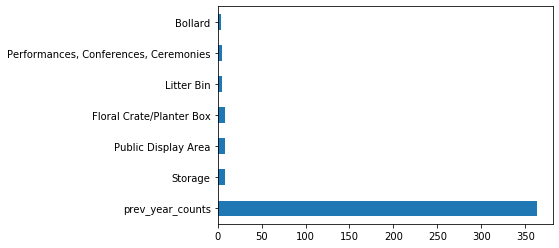

In [36]:
# 7 factors that have the greatest impact on predicting daily footfall counts
df_coef['coefficients'].sort_values(ascending = False)[:7].plot(kind='barh');

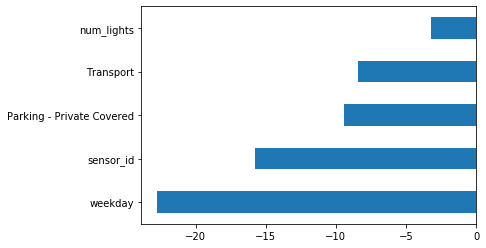

In [30]:
# 5 factors that have least impact on hourly counts
df_coef['coefficients'].sort_values(ascending = True)[:5].plot(kind='barh');

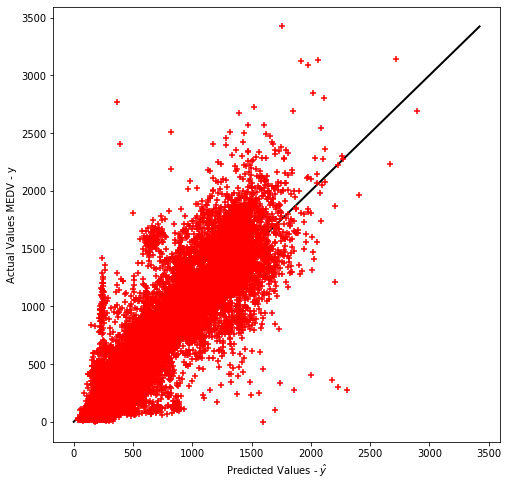

In [23]:
#predicted y values
predictions = best_model.predict(X_test)

#residuals (or error between predictions and actual)
residuals = y_test - predictions

# Plot predicted vs actual 
plt.figure(figsize=(8,8))
plt.scatter(predictions, y_test, s=30, c='r', marker='+', zorder=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], c='k', lw=2)
plt.xlabel("Predicted Values - $\hat{y}$")
plt.ylabel("Actual Values MEDV - y")
plt.show()

### Decision Tree Regressor

In [23]:
dtr_params = {
    'max_depth': [10, 15, 20],
    'max_features': [None],
    'min_samples_split': [48, 50, 52, 60, 70],
    'ccp_alpha': [0.004, 0.005, 0.006, 0.007]}

# set the gridsearch
model = DecisionTreeRegressor()

dtr_gs = GridSearchCV(model, dtr_params, cv=5, verbose=1, n_jobs=2)
dtr_gs.fit(X_train, y_train)
print(dtr_gs.best_params_)
best_model = dtr_gs.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   24.5s


{'ccp_alpha': 0.006, 'max_depth': 10, 'max_features': None, 'min_samples_split': 50}


[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:   36.8s finished


In [24]:
#{'ccp_alpha': 0.005, 'max_depth': 10, 'max_features': None, 'min_samples_split': 50}
# Training score:  0.9318641103420108
# Test score:  0.7726691799695199
# CV score:  0.7755289534003487

In [26]:
print('Training score: ', best_model.score(X_train, y_train))
print('Test score: ', best_model.score(X_test, y_test))
print('CV score: ', (cross_val_score(best_model, X_train, y_train)).mean())

Training score:  0.9318641103420108
Test score:  0.7714581127741083
CV score:  0.7668497986142154


### Ada Boost Regressor

In [21]:
base_estimator = DecisionTreeRegressor()

params = {'n_estimators': [71, 72, 73, 74, 75], 'learning_rate': [1.0], #.001, .01, .1, .5, .8,
         'loss': [ 'square' ]} #'linear','exponential'
model = AdaBoostRegressor(base_estimator=base_estimator,
                          random_state=1)

ada_cv = GridSearchCV(model, params, cv=5, verbose=1, n_jobs=2)

ada_cv.fit(X_train, y_train)
print(ada_cv.best_params_)
best_model = ada_cv.best_estimator_




Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:  5.9min finished


{'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 74}


In [ ]:
#{'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 70}
# Training score:  0.998341276457725
# Test score:  0.8285804223494496
# CV score:  0.8396797711244777

#{'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 75}
# Training score:  0.998290994561775
# Test score:  0.8278697054392621
# CV score:  0.840544556784628

#{'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 74}
# Training score:  0.9983166566529816
# Test score:  0.8275409714613514
# CV score:  0.8405586581229854

In [22]:
print('Training score: ', best_model.score(X_train, y_train))
print('Test score: ', best_model.score(X_test, y_test))
print('CV score: ', (cross_val_score(best_model, X_train, y_train)).mean())

Training score:  0.9983166566529816
Test score:  0.8275409714613514
CV score:  0.8405586581229854


# Use all sensors to predict just 2018

#### predict hourly counts with location, date and previous year's counts as predictors
#### using all valid sensors from 2011-2018
#### predict counts for 2018 with previous years as train data

*best CV score = Ada Boost Regressor 0.874

In [98]:
train = pd.concat([all_sen_2012, all_sen_2013, all_sen_2014, all_sen_2015, all_sen_2016, all_sen_2017], axis = 0, sort = True)
test = pd.concat([all_sen_2018], axis = 0, sort = True)

#remove sensor_id from predictors

train.pop('sensor_id')
test.pop('sensor_id')

X_train = train.copy()
y_train = X_train.pop('daily_avg_counts')

X_test = test.copy()
y_test = X_test.pop('daily_avg_counts')

### Ada Boost Regressor

In [101]:
base_estimator = DecisionTreeRegressor()

params = {'n_estimators': [75, 80, 85], 'learning_rate': [0.85, 0.9, .95], 'loss': ['square']}
model = AdaBoostRegressor(base_estimator=base_estimator,
                          random_state=1)

ada_cv = GridSearchCV(model, params, cv=5, verbose=1, n_jobs=2)

ada_cv.fit(X_train, y_train)
print(ada_cv.best_params_)
best_model = ada_cv.best_estimator_



Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  45 out of  45 | elapsed: 19.2min finished


{'learning_rate': 0.9, 'loss': 'square', 'n_estimators': 80}


In [ ]:
## with sensor id included

#{'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 71}
# Training score:  0.9987605835914849
# Test score:  0.8523777471089019
# CV score:  0.8822139478108436

#{'learning_rate': 1.0, 'loss': 'square', 'n_estimators': 60}
# Training score:  0.9989029209378538
# Test score:  0.8586228286379924
# CV score:  0.8849978086354005

##without sensor id included
# {'learning_rate': 0.9, 'loss': 'square', 'n_estimators': 80}
# Training score:  0.9994441664008715
# Test score:  0.9031665569172646
# CV score:  0.8743541418637856

In [105]:
print('Training score: ', best_model.score(X_train, y_train))
print('Test score: ', best_model.score(X_test, y_test))
print('CV score: ', (cross_val_score(best_model, X_train, y_train)).mean())

Training score:  0.9994441664008715
Test score:  0.9031665569172646
CV score:  0.8743541418637856


In [106]:
predictions = best_model.predict(X_test)


In [107]:
(mean_squared_error(y_test, predictions))**0.5

158.76326020224184

In [108]:
residuals_df = pd.DataFrame(predictions, y_test)
residuals_df.reset_index(inplace = True)
residuals_df.rename({'daily_avg_counts': 'y_test', 0: 'predictions'}, axis = 1, inplace = True)
residuals_df['residuals'] = residuals_df.y_test - residuals_df.predictions
residuals_df

y_test  predictions   residuals
0      1170.208333   722.458333  447.750000
1      1263.916667   982.541667  281.375000
2      1400.750000  1435.708333  -34.958333
3      1459.333333  1459.375000   -0.041667
4      1549.666667  1518.250000   31.416667
...            ...          ...         ...
13393   639.041667   751.958333 -112.916667
13394   704.500000   812.833333 -108.333333
13395   608.375000   634.541667  -26.166667
13396   527.500000   592.125000  -64.625000
13397   669.625000   857.125000 -187.500000

[13398 rows x 3 columns]

In [109]:
fi = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
})

fi.sort_values('importance', ascending=True, inplace=True)


Text(0, 0.5, 'Feature')

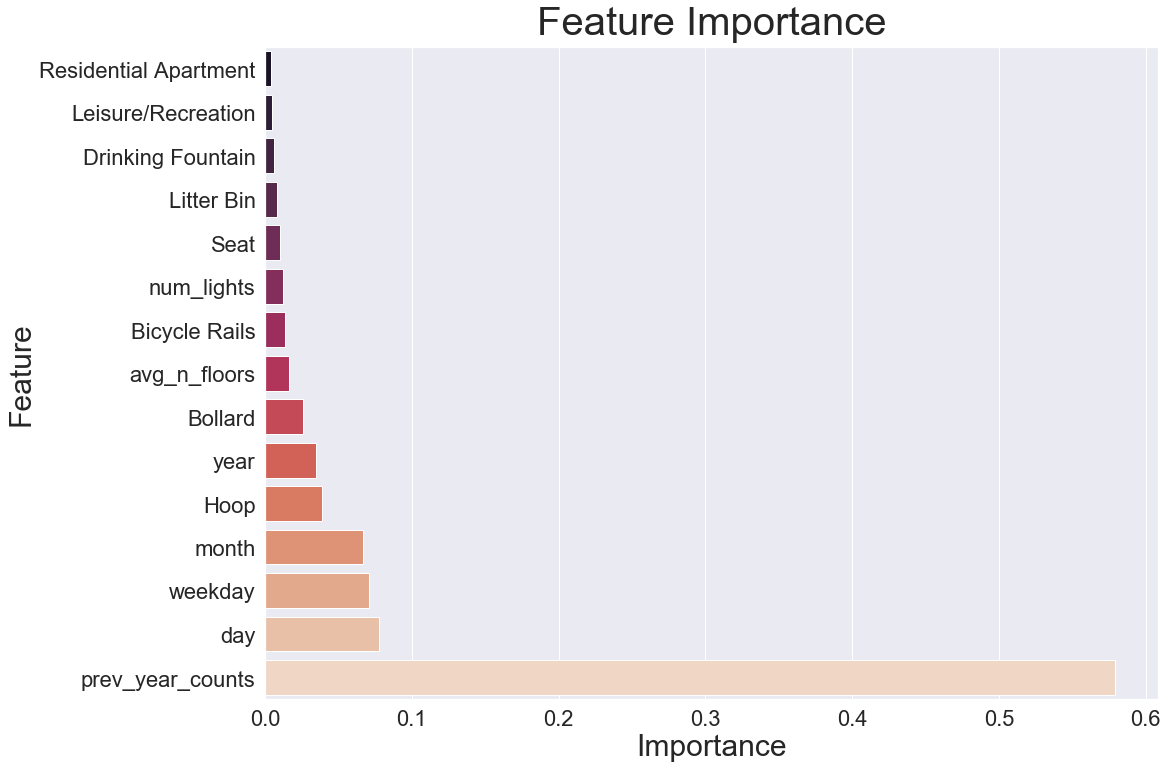

In [110]:
#sns.set_style('ticks')
sns.set(font_scale = 2)
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(16, 12)
sns.barplot(x='importance', y='feature', data=fi[-15:], orient='h', palette = 'rocket', saturation=0.7)  
ax.set_title("Feature Importance", fontsize=40, y=1.01)
ax.set_xlabel('Importance', fontsize = 30)
ax.set_ylabel('Feature', fontsize = 30)

Text(0, 0.5, 'Actual')

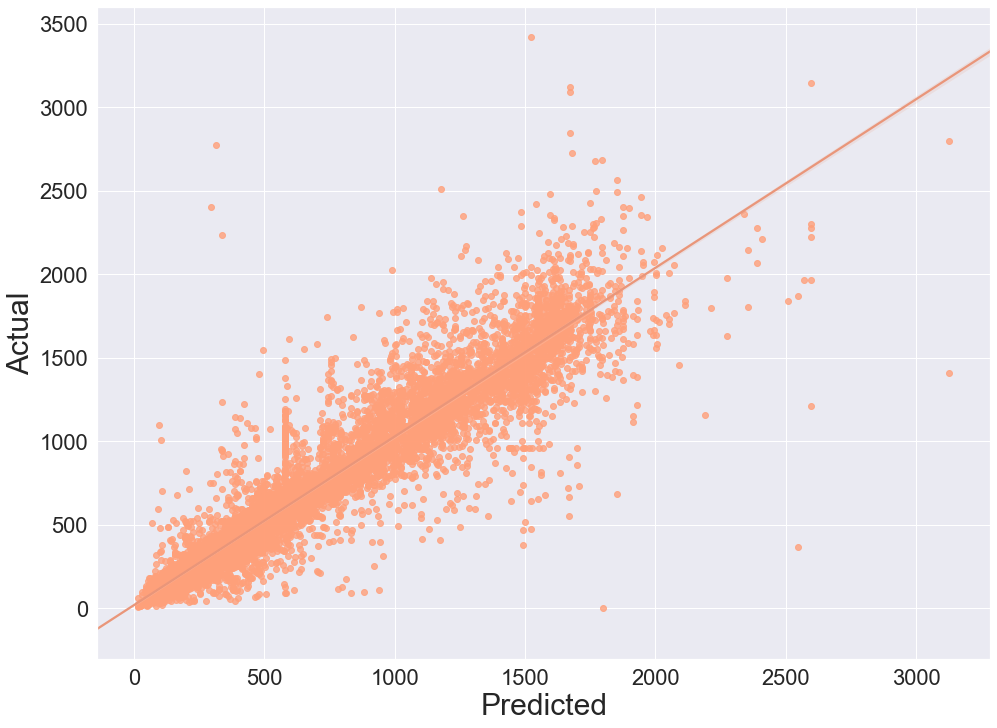

In [111]:
#predicted y values
predictions = best_model.predict(X_test)

#residuals (or error between predictions and actual)
residuals = y_test - predictions

sns.axes_style(style='white')

sns.set(font_scale = 2)
fig, ax = plt.subplots()
fig.set_size_inches(16, 12)
ax = sns.regplot(x="predictions", y="y_test", data= residuals_df,  scatter_kws = {'color': 'lightsalmon'}, 
                 line_kws = {'color': 'darksalmon'})
ax.set_xlabel('Predicted', fontsize = 30)
ax.set_ylabel('Actual', fontsize = 30)


### Decision Tree Regressor

In [37]:
dtr_params = {
    'max_depth': [5, 10, 15, 20,50],
    'max_features': [10, 50, None],
    'min_samples_split': [10, 20, 40, 50, 70],
    'ccp_alpha': [0.001, 0.005, 0.01, 0.1]}

# set the gridsearch
model = DecisionTreeRegressor()

dtr_gs = GridSearchCV(model, dtr_params, cv=5, verbose=1, n_jobs=2)
dtr_gs.fit(X_train, y_train)
print(dtr_gs.best_params_)
best_model = dtr_gs.best_estimator_

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   24.9s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.0min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed:  2.9min
[Parallel(n_jobs=2)]: Done 1500 out of 1500 | elapsed:  3.6min finished


{'ccp_alpha': 0.005, 'max_depth': 10, 'max_features': None, 'min_samples_split': 70}


In [38]:
print('Training score: ', best_model.score(X_train, y_train))
print('Test score: ', best_model.score(X_test, y_test))
print('CV score: ', (cross_val_score(best_model, X_train, y_train)).mean())

Training score:  0.9267420084089457
Test score:  0.7624814399889087
CV score:  0.849740484551322
